# Summary
In this notebook:
1. Load and train a model for mnist data set.
***
2. To improve the model perform hyper parameter tuning with the focus on learning rate.
    1. Created a call back that inherits from keras.callbacks.callback that gradually increases learning rate.
    2. Passed the callback to the model
    3. ran model for one epoch and plotted the callback saved loss values vs. saved rate values.
    4. Picked the best learning rate (half of the value when the loss started to go up again)
***
3. Using the learning rate found in step 2, created a model and 
    1. passed a callback to it for tensorboard (keras.callbacks.TensorBoard)
    2. passed a callback for early stopping (keras.callbacks.EarlyStopping)
    3. passed a calleback to save the best model during the training process(keras.callbacks.ModelCheckPoint)
***
Lessons learned:
* Restart the session before any run!!! otherwise there are gonna be some problems.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(X_train_all, y_train_all), (X_test, y_test )= keras.datasets.mnist.load_data()

# Exploratory Data Analysis

In [3]:
X_train_all.shape

(60000, 28, 28)

In [4]:
X_test.shape

(10000, 28, 28)

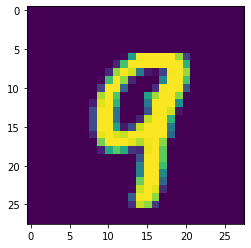

In [5]:
plt.imshow(X_train_all[800,:])

# Data Prepration

### Splitting train set into train and validation sets 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, train_size=0.917, random_state = 42)

In [7]:
X_train.shape

(55020, 28, 28)

In [8]:
y_valid.shape

(4980,)

In [9]:
X_valid.shape

(4980, 28, 28)

In [10]:
y_valid.shape

(4980,)

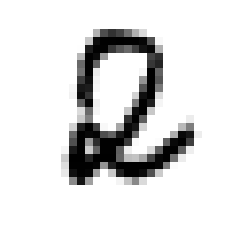

In [11]:
plt.imshow(X_valid[10,:], cmap="binary")
plt.axis('off')
plt.show()

### Feature Scaling (Standardization)

In [12]:
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

# Building Model

Lets build a deep network with 4 hidden layer, 1 output and 1 input layer.

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [18]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid))

In [ ]:
model.evaluate(X_test, y_test)

As show above, the accuracy reached 96.5%. Let's try hyper parameter tuning to increase accuracy. Goal is 98%.

# Searching for the best learning rate

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [ ]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=["accuracy"])

In [19]:
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [20]:
exponentialLRCallBack = ExponentialLearningRate(1.005)

In [21]:
history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_valid, y_valid),
                    callbacks=[exponentialLRCallBack])

1720/1720 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.4876 - val_loss: nan - val_accuracy: 0.1020


Text(0, 0.5, 'Loss')

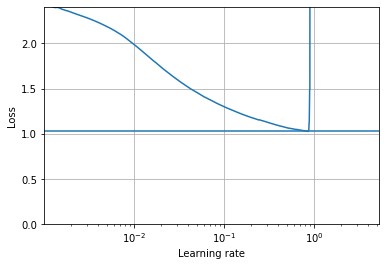

In [26]:
plt.plot(exponentialLRCallBack.rates, exponentialLRCallBack.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exponentialLRCallBack.losses), min(exponentialLRCallBack.rates), max(exponentialLRCallBack.rates))
plt.axis([min(exponentialLRCallBack.rates), max(exponentialLRCallBack.rates), 0, exponentialLRCallBack.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

it looks like it starts to go up around 3e-1. So we clear the session and run the model with lr = 3e-1

In [64]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [66]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [67]:
# tensorboard call back
import os

run_index = 2 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir
tensorboardCb = keras.callbacks.TensorBoard(run_logdir)

In [68]:
# Saving the best model call back
saveBestCb = keras.callbacks.ModelCheckpoint("Classification_MNIST_best.h5", save_best_only=True)

In [69]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=20),
                             tensorboardCb,
                             saveBestCb])

Epoch 1/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5614 - accuracy: 0.8238 - val_loss: 0.1684 - val_accuracy: 0.9474
Epoch 2/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1122 - accuracy: 0.9655 - val_loss: 0.1212 - val_accuracy: 0.9635
Epoch 3/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.0809 - accuracy: 0.9755 - val_loss: 0.0857 - val_accuracy: 0.9761
Epoch 4/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.1282 - val_accuracy: 0.9624
Epoch 5/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.1354 - val_accuracy: 0.9631
Epoch 6/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0761 - val_accuracy: 0.9783
Epoch 7/30
1720/1720 [==============================] - 5s 3ms/step - loss: 0.0284 - accuracy: 0.9905 - val_loss: 0.0696 - val_accuracy:

In [72]:
model = keras.models.load_model("Classification_MNIST_best.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 892us/step - loss: 0.0805 - accuracy: 0.9778


[0.08048716187477112, 0.9778000116348267]

In [78]:
%tensorboard --logdir=./my_mnist_logs --port=6007